In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
import scipy.stats as stats

In [2]:
pd.options.display.max_columns = 20

The carbon offset project data was downloaded in September 2022 from the CARB website: https://ww2.arb.ca.gov/our-work/programs/compliance-offset-program. The dataset includes several columns that are not relevant in this analysis. Replace filepath

In [3]:
ct_offset = pd.read_csv('Filepath/arboc_issuance_ev2.csv', sep = ';')
ct_offset = ct_offset.drop(columns=['Early Action/ Compliance', 'Section 95989(b) Documentation, if applicable', 'Project Documentation', 'Technical Advisor.1', 'Provides DEBS', 'Retired 1st Compliance Period (CA)', 'Retired 2nd Compliance Period (CA)', 'Retired 3rd Compliance Period (CA)', 'Retired for Compliance in Quebec', 'Comment'])

In [4]:
ct_offset['ARB Offset Credits Issued'] = [str(x) for x in ct_offset['ARB Offset Credits Issued']]
ct_offset['ARB Offset Credits Issued'] = [i.replace('.', '') for i in ct_offset['ARB Offset Credits Issued']]

The first step is to look at historical prices for carbon offset credits and make assumptions about their development until 2114

`prices`  includes the historical prices for carbon offset credits taken from CARB's website: https://ww2.arb.ca.gov/our-work/programs/cap-and-trade-program

In [5]:
prices = [['Nov-14', 12.10],
          ['Feb-15', 12.21],
          ['May-15', 12.29],
          ['Aug-15', 12.52],
          ['Nov-15', 12.73],
          ['Feb-16', 12.73],
          ['May-16', 12.73],
          ['Aug-16', 12.73],
          ['Nov-16', 12.73],
          ['Feb-17', 13.57],
          ['May-17', 13.80],
          ['Aug-17', 14.75],
          ['Nov-17', 15.06],
          ['Feb-18', 14.61],
          ['May-18', 14.65],
          ['Aug-18', 15.05],
          ['Nov-19', 15.31],
          ['Feb-19', 15.73],
          ['May-19', 17.45],
          ['Aug-19', 17.16],
          ['Nov-19', 17.00],
          ['Feb-20', 17.87],
          ['May-20', 16.68],
          ['Aug-20', 16.68],
          ['Nov-20', 16.93],
          ['Feb-21', 17.80],
          ['May-21', 18.80],
          ['Aug-21', 23.30],
          ['Nov-21', 28.26],
          ['Feb-22', 29.15],
          ['May-22', 30.85],
          ['Aug-22', 27.00]] 
prices = pd.DataFrame(prices, columns=['period', 'price'])

Extrapolate prices for the next 100 years: <br>
Take annual average prices for past prices. Assume a 2% inflation/growth rate (p.a.) for future price developments and project carbon credit prices over a 108-year timeframe. This rate reflects the most commonly used discount rate when calculating the net present value (NPV) of projects. 6% was used by the majority of projects as the real interest rate, which consists (Fisher Equation) of the nominal interest rate (4%) and the inflation rate, according to the project documentation of most projects. Therefore, a 2% annual increase is assumed in prices.

In [6]:
prices["year"] = prices.apply(lambda x: int(re.sub(".*-","20",x["period"])), axis = 1)
annual_prices = pd.DataFrame(range(2014,2123),columns=["year"])
annual_prices["price"] = 0
annual_prices['price'] = annual_prices['price'].astype(float) 
annual_avg=[np.mean(prices.loc[prices["year"]==i,"price"]) for i in range(2014,2023)]
annual_prices.loc[annual_prices.year<2023,"price"] = annual_avg
last_price = annual_prices.loc[annual_prices.year == 2022, 'price'].values[0]
last_price = last_price*1.02**(np.arange(2023, 2123)-2022)
annual_prices.loc[annual_prices.year > 2022, 'price'] = last_price
annual_prices.head() 

,year,price
0,2014,12.1000
1,2015,12.4375
2,2016,12.7300
3,2017,14.2950
4,2018,14.7700


**Plotting the carbon prices over time**

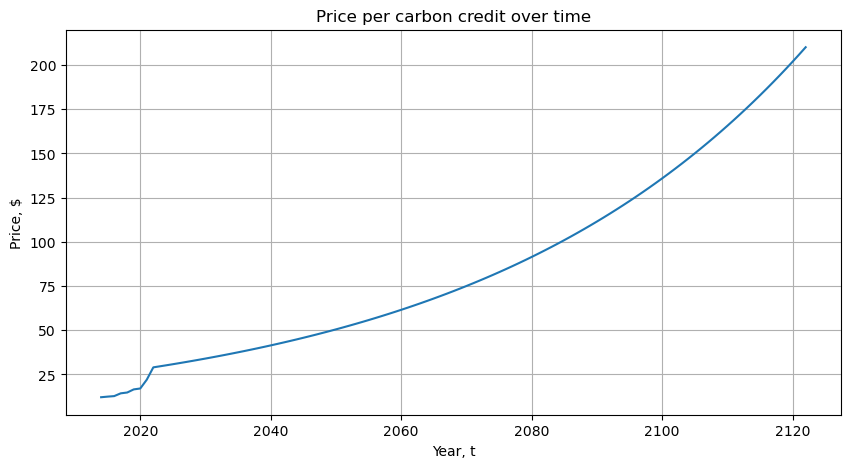

In [7]:
plt.figure(figsize=(10,5))
plt.plot(annual_prices['year'], annual_prices['price'])
plt.xlabel('Year, t')
plt.ylabel('Price, $')
plt.grid()
plt.title('Price per carbon credit over time')
plt.show()

The second step is to project the issuance of carbon credits over a 100-year timeframe for each offset project.

`offset` stores the CARB ID, number of credits, and date issued. 

In [8]:
offset = ct_offset[["CARB Issuance ID","OPR Project ID","ARB Offset Credits Issued","Issuance Date","Vintage"]].copy()
offset.columns = ["Name","ID","Credits","Date","Vintage"]
offset = offset.loc[offset["Date"] != " n/a "]
offset = offset.loc[offset["Credits"] != "nan"]
offset = offset.loc[pd.isna(offset["Date"]) == False]
offset["Year"] = offset.apply(lambda x: int("20"+str(x.Date)[-2:]), axis=1)
offset["Credits"] = [int(c) for c in offset["Credits"].values]
offset.loc[offset.Name == "CAFR5195-A","Credits"] = 573634 + 575728 + 2674895
offset = offset.drop([189,190], axis=0)
offset = offset.reset_index(drop=True)

`opos` stores a net present value (`NPV`) for all projects that have calculated it. `Baseline` shows the baseline year that was used by the offset project operator to discount the revenue. If the baseline year was not public, it was assumed that the end of the first reporting period is the baseline year, because that is the year in which the offset project operator decides to either submit a project for carbon credits or continue with its historical land use. `Discount` shows the discount value used for each financial analysis. If projects did not publish their discount value, 6% was assumed to be a reasonable assumption for two reasons. First, 6% was most commonly used among all projects. Second, 4% is a commonly used short-term interest rate, with 2% assumed inflation (=inflation target + see prices), the Fisher equation tells us that the long-term interest rate is 6%. `Unique` indicates whether a project has been issued continuous credits (TRUE) or only upfront credits (FALSE). `AVG` indicates average annual credits issuances based on either project reports (i.e., graphs that project forest growt) or regional carbon accumulation rates from the U.S. Forest Service. If `unique` is TRUE, then AVG is used for all years of issuance after the upfront credit issuance. If `unique` is FALSE (only for avoided conversion projects), then AVG includes the credits issuance after 2022. 
<br>
<br> <br>
The CSV file 'NP_values_projectrevenue-v2.csv' is from my data collection in which I went through the project documentation for each project and collected the net-present value of timber that the project operators had calculated as well as the discount rate they used. These values were used later when calculating the NPV of each offset project

In [ ]:
opos = pd.read_csv('Filepath/NP_values_projectrevenue-v2.csv', sep = ',')
opos["Baseline"] = opos["Baseline"].map('{:.0f}'.format)
opos.tail()

,ID,NPV,Baseline,Discount,Unique,AVG
115,CAR1391,61858609.0,2020,6.0,True,9241.00
116,CAR1436,NaN,nan,NaN,True,73875.10
117,CAR973,NaN,nan,NaN,False,NaN
118,CAR993,NaN,nan,NaN,False,NaN
119,VCSOPR10,NaN,nan,NaN,True,4807.77


**Extrapolation of credit issuance** <br>
Created a new DF called `projections`. For each project, I added the first entry (upfront credits), then the other related entries (continuous credits), and an approximation for projected credits as an extrapolation based on the average of the continuous credits. This procedure was done for 100 years for each project. The relevant columns are ID, which is preserved from the `offset` DF, Date (issuance date, only applicable for past issuances), Year (year of issue; any projections start at 2023), and Credits.

> Manual adjustment at the bottom: CAFR5208-6 is an avoided conversion project with 5/6 years of credit issuance for its avoided conversion. The value for 2022 was computed by regressing past data points and thus inferring this issuance.

In [10]:
projections = pd.DataFrame(columns=offset.columns)
unique_ids = np.unique(offset.ID.values)
num_projects_per_id = np.zeros(len(unique_ids))
for i in range(len(unique_ids)):
    id_ = unique_ids[i]
    entries = offset.loc[offset.ID == id_,:].copy()
    num_projects_per_id[i] = entries.shape[0]
    cont_avg = 0
    if entries.shape[0] == 1:
        opos_entry = opos.loc[opos.ID==id_]
        if np.isnan(opos_entry.AVG.values[0]) == False:
            cont_avg = np.round(opos_entry.AVG.values[0])
        cont_credits = []
    if entries.shape[0] > 1: 
        cont_credits = entries[1:]
        cont_avg = np.round(np.mean(cont_credits.Credits.values))
        opos_entry = opos.loc[opos.ID==id_]
        if np.isnan(opos_entry.AVG.values[0]) == False:
            cont_avg = np.round(opos_entry.AVG.values[0])
    if cont_avg > 0:
        rows_to_add = 100 - entries.shape[0]
        upfront = entries[0:1]
        upfront_name = upfront.Name.values[0][:-1]
        upfront.iloc[0,0] = upfront_name + "1"
        projections = pd.concat([projections,upfront])
        for j in range(len(cont_credits)):
            old_row = cont_credits[j:j+1]
            old_row.iloc[0,0] = upfront_name + str(j+2)
            projections = pd.concat([projections,old_row])
        for j in range(rows_to_add):
            new_row = upfront.copy()
            new_row.iloc[0,0] = upfront_name + str(j+2+len(cont_credits))
            new_row.iloc[0,2] = cont_avg
            new_row.iloc[0,3] = ""  
            new_row.iloc[0,4] = int(upfront.iloc[0,4]) + len(cont_credits) + j + 1
            issuance_year = upfront.iloc[0,5] + len(cont_credits) + j + 1
            if issuance_year < 2023:
                issuance_year = 2023
            new_row.iloc[0,5] = issuance_year
            projections = pd.concat([projections,new_row])
projections = projections.reset_index(drop=True)
projections.loc[projections.Name=="CAFR5208-6","Credits"] = 681897

**We test here whether it might make more sense to apply a linear or polynomial fit to the data points** <br>
This section is used to plot the continuous credits of projects and fit a linear or polynomial to project future developemt. This method was ultimately not used to forecast offset credit issuance since I can't forecast 90+ years using 2 to 6 existing data points. Instead, I opted for extrapolating based on averages issuance and take two values: 10 years of forest growth and 100 years of forest growth. The true value is likely to lie in between (as done in the cell above).

Creating a df with continuous credits, i.e., we omit the first entry.

In [11]:
cont_credits = pd.DataFrame(columns = projections.columns)
temp = projections.loc[projections.Date != ""].copy()
for proj in np.unique(temp.ID.values):
    project = temp.loc[temp.ID == proj]
    cont_credits = pd.concat([cont_credits, project.iloc[1:,:]])

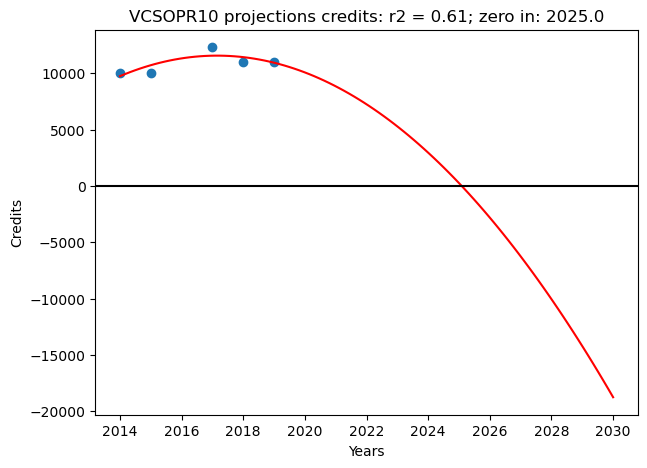

In [12]:
plotting = cont_credits.loc[cont_credits.ID == "ACR182"]

X = plotting["Vintage"].values.astype(int)
Y = plotting["Credits"].values.astype(int)
p = np.poly1d(np.polyfit(X,Y,deg=2)) # Adjusting the degree to get a linear (1) or polynomial (>1) fit.

plt.figure(figsize=(7, 5))
plt.scatter(X, Y)
years = np.linspace(2014,2030,100)
plt.plot(years, p(years),'r')
plt.axhline(0, color="k")
r2 = r2_score(Y, p(X))
null = np.round(p.r[0])
plt.title(str(proj) + " projections credits: r2 = " + str(np.round(r2, 2)) + "; zero in: " + str(null))
plt.xlabel("Years")
plt.ylabel("Credits")
plt.show()

**Result:** Extrapolation based on a linear or polinomial fit does not work as there are too few historical data points.

#### Continuing regular methodology

Add a column to `projections` with the revenue (in USD) for each year, based on the price of that year

In [13]:
projections["Revenue"] = projections["Credits"] * np.array([annual_prices.loc[annual_prices["year"] == i,"price"].values[0] for i in projections["Year"]])
projections.head()

,Name,ID,Credits,Date,Vintage,Year,Revenue
0,CAFR5028-1,ACR173,540828,27.01.15,2013,2015,6726548.25
1,CAFR5028-2,ACR173,8356,21.03.17,2014,2017,119449.02
2,CAFR5028-3,ACR173,45066,21.03.17,2015,2017,644218.47
3,CAFR5028-4,ACR173,3407,12.02.19,2016,2019,56317.71
4,CAFR5028-5,ACR173,18943,,2017,2023,560333.94


Add a column called `Revenue_Discounted` that discounts the revenue by the corresponsing interest rate that was also used for the net present value of harvest (Ranging from 4.5 to 10 percent). For projects that did not include their interest rate, 6% was assumed since that was the most commonly used discount value (the average was 6.45%, I rounded down for consistency with above).
<br>
<br>
For projects that provided their baseline year, that given year was used to discount credit value to npv. For projects that did not provide this information, the end of the first crediting period was used as the baseline year to make a comparison feasible. Since this year is likely the moment in time when OPOs make a decision about the offset project, this is a reasonable approach. So far, the baseline years are recorded in the column `Baseline` of the DF `opos`.
<br>
<br>
Add the years to the column baseline for the projects that do not have npv values. (Currently, the issuance year is being used to discount back)

In [ ]:
projections["Revenue_Discounted"] = 0
unique_ids = np.unique(projections.ID.values)
for i in range(len(unique_ids)):
    id_ = unique_ids[i]
    years = projections.loc[projections.ID==id_,"Year"].values
    baseline_year = years[0]
    discount = 1.06
    opos_entry = opos.loc[opos.ID==id_]
    if opos_entry.Baseline.values[0] != "nan":
        baseline_year = int(opos_entry.Baseline.values[0])
    if np.isnan(opos_entry.Discount.values[0]) == False:
        discount = 1 + opos_entry.Discount.values[0]/100
    years = years - baseline_year
    revenue = projections.loc[projections.ID==id_,"Revenue"]
    projections["Revenue_Discounted"] = projections["Revenue_Discounted"].astype(float)
    projections.loc[projections.ID==id_,"Revenue_Discounted"] = revenue/(discount**years)

`group_summary`: a summary of IDs, the baseline years and the sum of discounted revenues. 
<br> > Import OPOS: offset project operator's calculated net present values (NPV)
<br> > Next, we added OPOs wherever possible. 
<br> > Finally round each number and add commas. 
<br> > Two different npvs were calculated. One that assumes that the credits will be issued for 20 years after project initiation and one that assumes that carbon credits will be issued for 100 years. The true value will lie in between those two npvs.
<br> > Group data by technical advisor and calculate mean and median of credits issued for non-additional projects
<br> > This was only done for projects that had a NPV from the offset project operator
> **Group summary: Columns**
> <br> `Baseline_Year`: the year the revenue was discounted back to and the year the project was registered
> <br> `OPOs`: The net-present value that the offset project operator calculated for the non-carbon offset project scenario (i.e., the scenario in which the forest is not enrolled in the offset project and is harvested in a business-as-usual scenario)
> <br>`Revenue_Discounted_10_years`: The NPV for the revenue assuming the forest grows for 10 years after offset project registration
> <br>`Revenue_Discounted`: The NPV for the revenue assuming the forest grows for 100 years after offset project registration
> <br>`NPV_diff`: The difference in NPV between the `Revenue_Discounted` value and the `OPOs` value
> <br>`NPV_diff_10`: The difference in the `Revenue_Discounted_10_years` value and the `OPOs` value
> <br>`Rel_diff_10/100`: `NPV_diff_10` / `NPV_diff` to get an estimate of how much more revenue accrues if the forest grows for longer (i.e., check for robustness of methodology)

In [19]:
group_summary = projections[["ID","Revenue_Discounted"]].groupby(by=["ID"]).sum()
group_summary["Baseline_Year"] = projections[["ID","Year"]].groupby(by=["ID"]).min()
group_summary = group_summary.reset_index()
group_summary["OPOs"] = [opos.loc[opos["ID"]==x,"NPV"].values[0] for x in group_summary.ID]
group_summary["Revenue_Discounted_10_years"] = [sum(projections.loc[projections.ID==id_,"Revenue_Discounted"][0:10]) for id_ in group_summary.ID.values]
group_summary["NPV_diff"] = group_summary["Revenue_Discounted"] - group_summary["OPOs"]
group_summary["NPV_diff_10"] = group_summary["Revenue_Discounted_10_years"] - group_summary["OPOs"]
group_summary["OPOs"] = group_summary["OPOs"].round()
group_summary["Revenue_Discounted"] = group_summary["Revenue_Discounted"].round()
group_summary["Revenue_Discounted_10_years"] = group_summary["Revenue_Discounted_10_years"].round()
group_summary["NPV_diff"] = group_summary["NPV_diff"].round()
group_summary["NPV_diff_10"] = group_summary["NPV_diff_10"].round()
group_summary["Rel_diff_10/100"] = group_summary["NPV_diff_10"]/group_summary["NPV_diff"]*100
group_summary["Rel_diff_10/100"] = group_summary["Rel_diff_10/100"].round(2)
group_summary.head()

,ID,Revenue_Discounted,Baseline_Year,OPOs,Revenue_Discounted_10_years,NPV_diff,NPV_diff_10,Rel_diff_10/100
0,ACR173,17902815.66297,2015,NaN,9546915.0,NaN,NaN,NaN
1,ACR182,7488536.323815,2014,NaN,2788146.0,NaN,NaN,NaN
2,ACR189,7297669.385326,2014,NaN,4140291.0,NaN,NaN,NaN
3,ACR192,7092448.59814,2015,NaN,3556530.0,NaN,NaN,NaN
4,ACR199,99084114.016781,2014,NaN,37742050.0,NaN,NaN,NaN


#### This section derives summary statistics for project additionality

Average difference in NPVs for 100 years, ignoring missing data: 

In [20]:
print(np.round(np.nanmean(group_summary.NPV_diff.values)))

36541264.0


Average diff in NPVs for 10 years of issued credits in the future

In [21]:
print(np.round(np.nanmean(group_summary.NPV_diff_10.values)))

3368214.0


Number of projects with negative diff and positive diff

In [22]:
print(sum(group_summary.NPV_diff.values < 0))
print(sum(group_summary.NPV_diff.values > 0))

18
50


For 10 years: Number of projects with negative diff and positive diff

In [23]:
print(sum(group_summary.NPV_diff_10.values < 0))
print(sum(group_summary.NPV_diff_10.values > 0))

32
36


#### Plotting section

Create a new df `compl`, including data from the `group_summary` without any NaNs and in millions of USD. 

In [24]:
compl = group_summary[pd.notna(group_summary["OPOs"])]
compl = compl.sort_values("Revenue_Discounted", ascending=False)
compl["Revenue_Discounted"] = compl["Revenue_Discounted"]/1000000
compl["Revenue_Discounted_10_years"] = compl["Revenue_Discounted_10_years"]/1000000
compl["OPOs"] = compl["OPOs"]/1000000
compl["NPV_diff"] = compl["NPV_diff"]/1000000
compl["NPV_diff_10"] = compl["NPV_diff_10"]/1000000

For discussion: Compare normalized distributions of NPVs

In [25]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

norm_opos = NormalizeData(compl.OPOs)
compl["Normalized_opos"] = norm_opos
norm_rev_dis = NormalizeData(compl.Revenue_Discounted)
compl["Normalized_revenue_dis"] = norm_rev_dis
norm_rev_dis_10 = NormalizeData(compl.Revenue_Discounted_10_years)
compl["Normalized_revenue_dis_10"] = norm_rev_dis_10
norm_rev_dis_10 = NormalizeData(compl.Revenue_Discounted_10_years)
compl["Normalized_revenue_dis_10"] = norm_rev_dis_10

For correlation heatmap -> Appendix

In [26]:
compl_matrix = compl[["Baseline_Year", "OPOs", "Revenue_Discounted", "Revenue_Discounted_10_years", "NPV_diff", "NPV_diff_10"]]
correlas = pd.DataFrame(compl_matrix)
correlas.columns = ["Baseline Year", "Timber NPVs", "100y. Credit NPVs", "10y. Credit NPVs", "100y. NPV Diff.", "10y. NPV Diff."]

[Text(0.5, 1.0, 'Correlation between results')]

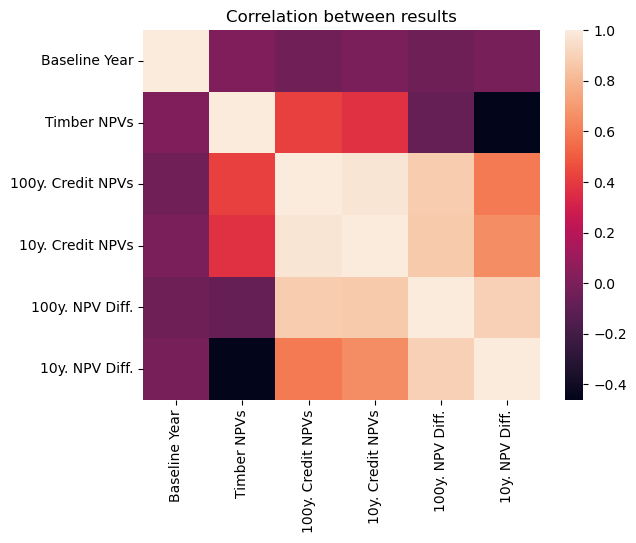

In [27]:
sns.heatmap(correlas.corr()).set(title='Correlation between results')

Plot the distributions in a histogram

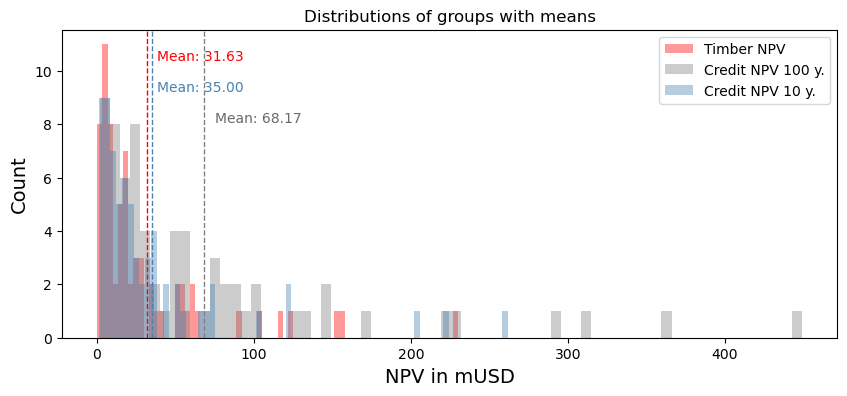

In [28]:
x = compl["OPOs"]
y = compl["Revenue_Discounted"]
z = compl["Revenue_Discounted_10_years"]

plt.figure(figsize=(10,4))
plt.hist(x, bins=70, alpha=0.4, label="Timber NPV", color="red")
plt.hist(y, bins=70, alpha=0.4, label="Credit NPV 100 y.", color="gray")
plt.hist(z, bins=70, alpha=0.4, label="Credit NPV 10 y.", color="steelblue")

plt.xlabel("NPV in mUSD", size=14)
plt.ylabel("Count", size=14)
plt.title("Distributions of groups with means")
plt.legend(loc='upper right')

plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(y.mean(), color='gray', linestyle='dashed', linewidth=1)
plt.axvline(z.mean(), color='steelblue', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.2f}'.format(x.mean()), color="red")
plt.text(y.mean()*1.1, max_ylim*0.7, 'Mean: {:.2f}'.format(y.mean()), color="dimgrey")
plt.text(z.mean()*1.1, max_ylim*0.8, 'Mean: {:.2f}'.format(z.mean()), color="steelblue")
plt.show()

Comparing the differences between timber and credit revenue

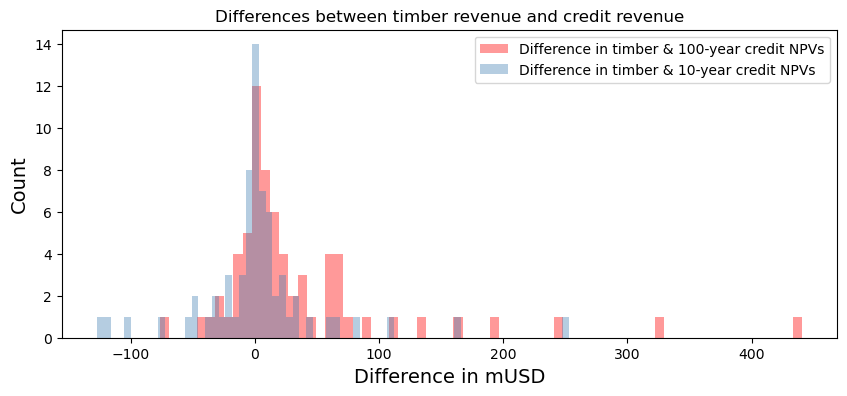

In [29]:
c = compl["NPV_diff"]
t = compl["NPV_diff_10"]

plt.figure(figsize=(10,4))
plt.hist(c, bins=70, alpha=0.4, label="Difference in timber & 100-year credit NPVs", color="red")
plt.hist(t, bins=70, alpha=0.4, label="Difference in timber & 10-year credit NPVs", color="steelblue")

plt.xlabel("Difference in mUSD", size=14)
plt.ylabel("Count", size=14)
plt.title("Differences between timber revenue and credit revenue")
plt.legend(loc='upper right')
plt.show()

Creating overview plots (plot the last cell multiple times for `bars 1`, 2, 3 & 4)

In [30]:
# Add a sign when the NPV difference indicates additionality/non-additionality (for 10 and 100 years)
x_values = compl["NPV_diff_10"].unique()
differ = []
for x in x_values:
    if x <= 0:
        differ.append("*")
    else:
        differ.append("")
compl["ID_mn"] = compl["ID"] + " " + differ

y_values = compl["NPV_diff"].unique()
some = []
for y in y_values:
    if y <= 0:
        some.append("¹")
    else:
        some.append("")
compl["ID_n"] = compl["ID_mn"] + some

In [31]:
compl.drop(columns="ID_mn")
bars1 = compl[0:17]
bars2 = compl[17:34]
bars3 = compl[34:51]
bars4 = compl[51:69]

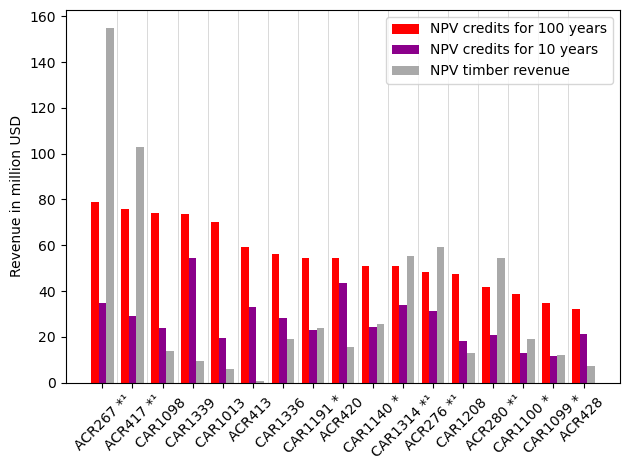

In [32]:
baro = bars2
labels = baro["ID_n"].values
rev_disc_100 = baro["Revenue_Discounted"].values
rev_disc_10 = baro["Revenue_Discounted_10_years"].values
proj_rev = baro["OPOs"]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, rev_disc_100, width, label='NPV credits for 100 years', color = "red")
rects2 = ax.bar(x, rev_disc_10, width, label='NPV credits for 10 years', color = "darkmagenta")
rects2 = ax.bar(x + width, proj_rev, width, label='NPV timber revenue', color = "darkgray")

ax.set_ylabel('Revenue in million USD')
ax.set_title('')
ax.set_xticks(x, labels, rotation = 45)
ax.legend()

xpoints = x+width*2
xpoints = xpoints[0:16]

for p in xpoints:
    ax.axvline(p, linewidth=0.6, color="lightgray")

fig.tight_layout()